# Цель проекта

Цель проекта — подготовить, очистить и исследовать данные о стартапах, чтобы помочь финансовой компании оценить перспективы выхода на рынок инвестиций путём покупки, развития и последующей перепродажи стартапов. В рамках проекта необходимо:
объединить данные из разных таблиц на основе логичных ключей;
проверить корректность и надёжность информации, особенно по персоналу и образовательному уровню;
интерпретировать аномальные значения (например, сделки на $0 или $1);
проанализировать стоимость стартапов в зависимости от категории и количества инвестиционных раундов;
вычислить ключевые численные показатели и их динамику;
идентифицировать потенциальные признаки успешных сделок.

# Описание данных

Таблица acquisition cодержит информацию о покупках одними компаниями других компаний: id — идентификатор покупки, acquiring_company_id — идентификатор покупающей компании, acquired_company_id — идентификатор покупаемой компании, term_code — варианты расчёта, price_amount — сумма сделки, acquired_at — дата сделки.

Таблица company_and_rounds cодержит информацию о компаниях и раундах финансирования:
company ID — идентификатор компании, name — название компании, category code — категория области деятельности компании, status — статус компании, founded at — дата инвестирования, closed at — дата закрытия компании, domain — официальный сайт компании, network username — ник компании в сети,
country code — код страны компании, investment rounds — число инвестиционных раундов, funding rounds — число раундов финансирования, funding total — сумма финансирования, milestones — вехи финансирования, funding round id — идентификатор этапа финансирования, company id — идентификатор компании,
funded at — дата финансирования, funding round type — тип финансирования, raised amount — сумма финансирования, pre money valuation — предварительная денежная оценка, participants — число участников, is first round — является ли раунд первым, is last round — является раунд последним.

Таблица education cодержит информацию об образовании сотрудника:
id — идентификатор записи об образовании, person_id — идентификатор работника, instituition — название учебного заведения, graduated_at — дата получения образования.

Таблица people cодержит информацию о сотрудниках:
id — идентификатор сотрудника, first_name — имя сотрудника, last_name — фамилия сотрудника, company_id — идентификатор компании, network_username — ник в социальных сетях.

Таблица degrees cодержит информацию о типе образования сотрудника:
id — идентификатор записи, object_id — идентификатор сотрудника, degree_type — тип образования, subject — специальность.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
try:
    df_acquisition = pd.read_csv('acquisition.csv')
except FileNotFoundError:
    df_acquisition = pd.read_csv('https://code.s3.yandex.net/datasets/acquisition.csv')

try:
    df_company_and_rounds = pd.read_csv('company_and_rounds.csv')
except FileNotFoundError:
    df_company_and_rounds = pd.read_csv('https://code.s3.yandex.net/datasets/company_and_rounds.csv')

try:
    df_people = pd.read_csv('people.csv')
except FileNotFoundError:
    df_people = pd.read_csv('https://code.s3.yandex.net/datasets/people.csv')

try:
    df_degrees = pd.read_csv('degrees.csv')
except FileNotFoundError:
    df_degrees = pd.read_csv('https://code.s3.yandex.net/datasets/degrees.csv')

try:
    df_education = pd.read_csv('education.csv')
except FileNotFoundError:
    df_education = pd.read_csv('https://code.s3.yandex.net/datasets/education.csv')


## Знакомство с данными: загрузка и первичная предобработка

Загрузим необходимые библиотеки для анализа данных и данные из датасетов. Затем выведем основную информацию о данных с помощью метода info() и первые строки датафреймов.

In [3]:
df_acquisition.head()

,id,acquiring_company_id,acquired_company_id,term_code,price_amount,acquired_at
0,1,11,10,NaN,20000000,2007-05-30
1,7,59,72,cash,60000000,2007-07-01
2,8,24,132,cash,280000000,2007-05-01
3,9,59,155,cash,100000000,2007-06-01
4,10,212,215,cash,25000000,2007-07-01


In [4]:
df_acquisition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9407 entries, 0 to 9406
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    9407 non-null   int64 
 1   acquiring_company_id  9407 non-null   int64 
 2   acquired_company_id   9407 non-null   int64 
 3   term_code             1831 non-null   object
 4   price_amount          9407 non-null   int64 
 5   acquired_at           9378 non-null   object
dtypes: int64(4), object(2)
memory usage: 441.1+ KB


В таблице находится 6 столбцов и 9407 строк. Данные хранятся в двух типах данных - int64, object. В столбцах price_amount, term_code, acquired_at имеются пропуски. Название столбцов корректно и не требует доработки. 

In [5]:
df_company_and_rounds.head()

,company ID,name,category code,status,founded at,closed at,domain,network username,country code,investment rounds,...,milestones,funding round id,company id,funded at,funding round type,raised amount,pre money valuation,participants,is first round,is last round
0,1.0,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,BachelrWetpaint,USA,0.0,...,5.0,888.0,1.0,2005-10-01,series-a,5250000.0,0.0,2.0,0.0,1.0
1,1.0,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,BachelrWetpaint,USA,0.0,...,5.0,889.0,1.0,2007-01-01,series-b,9500000.0,0.0,3.0,0.0,0.0
2,1.0,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,BachelrWetpaint,USA,0.0,...,5.0,2312.0,1.0,2008-05-19,series-c+,25000000.0,0.0,4.0,1.0,0.0
3,10.0,Flektor,games_video,acquired,NaN,NaN,flektor.com,NaN,USA,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100.0,There,games_video,acquired,NaN,NaN,there.com,NaN,USA,0.0,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_company_and_rounds.columns

Index(['company  ID', 'name', 'category  code', 'status', 'founded  at',
       'closed  at', 'domain', 'network  username', 'country  code',
       'investment  rounds', 'funding  rounds', 'funding  total', 'milestones',
       'funding  round  id', 'company  id', 'funded  at',
       'funding  round  type', 'raised  amount', 'pre  money  valuation',
       'participants', 'is  first  round', 'is  last  round'],
      dtype='object')

Названия столбцов не стандартизированы - многие названия содержат пробелы и неоднородное форматирование (company ID, category code, pre money valuation). Необходимо приведение к нижнему регистру и к формату snake_case. 

In [7]:
def col_to_snake_case(df):
    new_columns = {}
    for col in df.columns:
        col_new = col.strip().lower().replace('  ', ' ').replace(' ', '_')
        new_columns[col] = col_new
    return df.rename(columns=new_columns)

df_company_and_rounds = col_to_snake_case(df_company_and_rounds)

In [8]:
df_company_and_rounds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217774 entries, 0 to 217773
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   company_id           217472 non-null  float64
 1   name                 217472 non-null  object 
 2   category_code        143886 non-null  object 
 3   status               217472 non-null  object 
 4   founded_at           109956 non-null  object 
 5   closed_at            3449 non-null    object 
 6   domain               147159 non-null  object 
 7   network_username     95534 non-null   object 
 8   country_code         108607 non-null  object 
 9   investment_rounds    217472 non-null  float64
 10  funding_rounds       217472 non-null  float64
 11  funding_total        217472 non-null  float64
 12  milestones           217472 non-null  float64
 13  funding_round_id     52928 non-null   float64
 14  company_id           52928 non-null   float64
 15  funded_at        

В таблице находится 22 столбца и 217774 строки. Данные хранятся в двух типах данных - float64, object. В данных большое количество пропусков, в некоторых столбцах больше 50%

In [9]:
df_people.head()

,id,first_name,last_name,company_id,network_username
0,10,Mark,Zuckerberg,5.0,NaN
1,100,Peter,Lester,27.0,NaN
2,1000,Dr. Steven,E. Saunders,292.0,NaN
3,10000,Neil,Capel,2526.0,NaN
4,100000,Sue,Pilsch,NaN,NaN


In [10]:
df_people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226709 entries, 0 to 226708
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                226709 non-null  int64  
 1   first_name        226704 non-null  object 
 2   last_name         226708 non-null  object 
 3   company_id        34615 non-null   float64
 4   network_username  38867 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 8.6+ MB


В таблице находится 5 столбцов и 226709 строки. Данные хранятся в трех типах данных - float64, object,int64. Названия столбцов стандартизированы и не требуют доработки. Большое количество пропусков в столбцах company_id и network_username.

In [11]:
df_degrees.head()

,id,object_id,degree_type,subject
0,1,p:6117,MBA,NaN
1,2,p:6136,BA,"English, French"
2,3,p:6136,MS,Mass Communication
3,4,p:6005,MS,Internet Technology
4,5,p:5832,BCS,"Computer Science, Psychology"


In [12]:
df_degrees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109610 entries, 0 to 109609
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           109610 non-null  int64 
 1   object_id    109610 non-null  object
 2   degree_type  98392 non-null   object
 3   subject      81298 non-null   object
dtypes: int64(1), object(3)
memory usage: 3.3+ MB


В таблице находится 4 столбца и 109610 строки. Данные хранятся в двух типах данных - object,int64. Названия столбцов стандартизированы и не требуют доработки. Имеются пропуски

In [13]:
df_education.head()

,id,person_id,instituition,graduated_at
0,1,6117,NaN,NaN
1,2,6136,"Washington University, St. Louis",1990-01-01
2,3,6136,Boston University,1992-01-01
3,4,6005,University of Greenwich,2006-01-01
4,5,5832,Rice University,NaN


In [14]:
df_education.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109610 entries, 0 to 109609
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            109610 non-null  int64 
 1   person_id     109610 non-null  int64 
 2   instituition  109555 non-null  object
 3   graduated_at  58054 non-null   object
dtypes: int64(2), object(2)
memory usage: 3.3+ MB


В таблице находится 4 столбца и 109610 строки. Данные хранятся в двух типах данных - object,int64. Названия столбцов указаны корректно

## Смена типов и анализ пропусков

In [15]:
df_acquisition.isna().sum().sort_values(ascending = False)

term_code               7576
acquired_at               29
id                         0
acquiring_company_id       0
acquired_company_id        0
price_amount               0
dtype: int64

In [16]:
share_df_acquisition_missing = (df_acquisition.isna().sum()/df_acquisition.shape[0]*100).sort_values(ascending = False)
print(share_df_acquisition_missing)

term_code               80.535771
acquired_at              0.308281
id                       0.000000
acquiring_company_id     0.000000
acquired_company_id      0.000000
price_amount             0.000000
dtype: float64


Наибольшее количество пропусков — в столбце term_code: 80.5%. Это критично.
В acquired_at пропущено совсем немного — 0.31%. Остальные столбцы (id, acquiring_company_id, acquired_company_id, price_amount) полностью заполнены.

In [17]:
df_acquisition['acquired_at'] = pd.to_datetime(df_acquisition['acquired_at'], errors = 'coerce')

In [18]:
df_acquisition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9407 entries, 0 to 9406
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    9407 non-null   int64         
 1   acquiring_company_id  9407 non-null   int64         
 2   acquired_company_id   9407 non-null   int64         
 3   term_code             1831 non-null   object        
 4   price_amount          9407 non-null   int64         
 5   acquired_at           9378 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 441.1+ KB


Изменили тип данных на соответствующий дате. Теперь весь столбец имеет тип данных, удобный для работы с датами, например, для сортировки, фильтрации, вычислений и визуализации.

In [19]:
df_company_and_rounds.isna().sum().sort_values(ascending = False)

closed_at              214325
funded_at              165094
is_last_round          164846
is_first_round         164846
participants           164846
pre_money_valuation    164846
raised_amount          164846
funding_round_type     164846
funding_round_id       164846
company_id             164846
network_username       122240
country_code           109167
founded_at             107818
category_code           73888
domain                  70615
company_id                302
milestones                302
name                      302
funding_rounds            302
investment_rounds         302
status                    302
funding_total             302
dtype: int64

In [20]:
share_df_company_and_rounds = (df_company_and_rounds.isna().sum()/df_company_and_rounds.shape[0]*100).sort_values(ascending = False)
print(share_df_company_and_rounds)

closed_at              98.416248
funded_at              75.809784
is_last_round          75.695905
is_first_round         75.695905
participants           75.695905
pre_money_valuation    75.695905
raised_amount          75.695905
funding_round_type     75.695905
funding_round_id       75.695905
company_id             75.695905
network_username       56.131586
country_code           50.128574
founded_at             49.509124
category_code          33.928752
domain                 32.425818
company_id              0.138676
milestones              0.138676
name                    0.138676
funding_rounds          0.138676
investment_rounds       0.138676
status                  0.138676
funding_total           0.138676
dtype: float64


Очень много пропусков в столбце closed_at, в котором содержиться информация о закрытии компании. Можно предположить, что закрылись около 2% компаний, остальные продолжают свою работу. 9 столбцов содержит около 75% пропусков. Практически полные данные содержаться в 7 столбцах. 

In [21]:
for col in ['founded_at', 'funded_at']:
    df_company_and_rounds[col] = pd.to_datetime(df_company_and_rounds[col], errors = 'coerce')

In [22]:
df_people.isna().sum().sort_values(ascending = False)

company_id          192094
network_username    187842
first_name               5
last_name                1
id                       0
dtype: int64

In [23]:
share_df_people = (df_people.isna().sum()/df_people.shape[0]*100).sort_values(ascending = False)
print(share_df_people)

company_id          84.731528
network_username    82.855996
first_name           0.002205
last_name            0.000441
id                   0.000000
dtype: float64


Много пропусков почти 85% и 83% собержится в столбцах company_id, network_username.

In [24]:
df_education.isna().sum().sort_values(ascending = False)

graduated_at    51556
instituition       55
id                  0
person_id           0
dtype: int64

In [25]:
share_df_education = (df_education.isna().sum()/df_education.shape[0]*100).sort_values(ascending = False)
print(share_df_education)

graduated_at    47.035854
instituition     0.050178
id               0.000000
person_id        0.000000
dtype: float64


Данные почти полные, за исключением столбца graduated_at, в котором пропуски составляют почти 47%

In [26]:
df_education['graduated_at'] = pd.to_datetime(df_education['graduated_at'], errors = 'coerce')

In [27]:
df_degrees.isna().sum().sort_values(ascending = False)

subject        28312
degree_type    11218
id                 0
object_id          0
dtype: int64

In [28]:
share_df_degrees = (df_degrees.isna().sum()/df_degrees.shape[0]*100).sort_values(ascending = False)
print(share_df_degrees)

subject        25.829760
degree_type    10.234468
id              0.000000
object_id       0.000000
dtype: float64


Пропуски в столбцах subject и degree_type, 25% и 10% соответственно. 

Несмотря на наличие пропусков, данных достаточно для выполнения большинства аналитических задач проекта. 

## Предобработка данных, предварительное исследование

In [29]:
pd.options.display.float_format = '{:,.0f}'.format
df_company_and_rounds['year'] = df_company_and_rounds['funded_at'].dt.year.astype('Int64')
pivot_table_funding = pd.pivot_table(
    df_company_and_rounds,
    index='year',
    values='raised_amount',
    aggfunc=['count', 'median']
)

pivot_table_funding.columns = ['count_funding_rounds', 'average_raised_amount']
print(pivot_table_funding)

      count_funding_rounds  average_raised_amount
year                                             
1960                     9                      0
1973                     1                      0
1974                     2                      0
1984                     3                 41,000
1985                     1                      0
1987                     2              1,250,000
1989                     1                 15,000
1990                     1              1,000,000
1992                     1              2,000,000
1993                     2                 62,500
1994                     2              6,700,000
1995                     7              2,000,000
1996                     7                 12,500
1997                     9              3,300,000
1998                    29                100,000
1999                    76              2,000,000
2000                   125              4,200,000
2001                    96              3,000,000


In [30]:
filtered_pivot_table_funding = pivot_table_funding[pivot_table_funding['count_funding_rounds']>50]
print(filtered_pivot_table_funding)

      count_funding_rounds  average_raised_amount
year                                             
1999                    76              2,000,000
2000                   125              4,200,000
2001                    96              3,000,000
2002                   116              4,200,000
2003                   159              3,000,000
2004                   291              5,000,000
2005                  1633              5,500,000
2006                  2436              5,000,000
2007                  3279              3,973,320
2008                  3774              3,110,000
2009                  4151              2,000,000
2010                  6221              1,602,500
2011                  9204              1,200,000
2012                  9970              1,000,000
2013                 11072              1,200,000


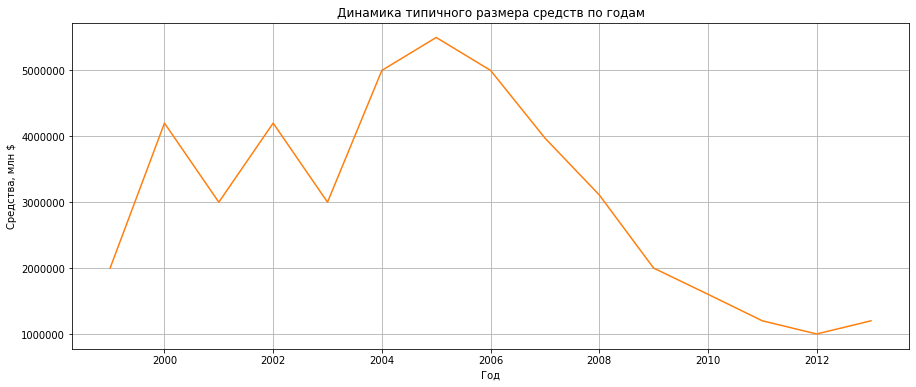

In [31]:
filtered_pivot_table_funding['average_raised_amount'].plot(
    kind='line',
    figsize=(15, 6),
    legend=False,
    color='#ff7f0e',
    title='Динамика типичного размера средств по годам'
)

plt.ylabel('Средства, млн $')
plt.xlabel('Год')
plt.grid(True)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Максимальный типичный размер средств в одном раунде наблюдался в 2005 году — 5,5 млн долларов. Это пик среди всех лет, представленных в таблице.
В 2013 году наблюдается:
максимальное число раундов финансирования — 11 072, что говорит о высоком интересе инвесторов к стартапам;
типичный размер привлечённых средств — 1,2 млн долларов, что значительно ниже пиковых значений начала 2000-х годов.
Это свидетельствует о том, что несмотря на рост количества сделок, средние суммы инвестиций в отдельный раунд стали заметно меньше, что может быть связано с ростом числа стартапов, ранними стадиями финансирования или изменением стратегии инвесторов.

### Люди и их образование

In [32]:
df_people.head(20)

,id,first_name,last_name,company_id,network_username
0,10,Mark,Zuckerberg,5,NaN
1,100,Peter,Lester,27,NaN
2,1000,Dr. Steven,E. Saunders,292,NaN
3,10000,Neil,Capel,"2,526",NaN
4,100000,Sue,Pilsch,NaN,NaN
5,100002,Keith,Kurzendoerfer,NaN,NaN
6,100006,Courtney,Homer,"81,558",jobsbostontech
7,100009,Eddy,Badrina,NaN,NaN
8,100010,Michael,Dadashyan,NaN,fbroulette
9,100011,Jeff,Grell,NaN,NaN


In [33]:
df_people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226709 entries, 0 to 226708
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                226709 non-null  int64  
 1   first_name        226704 non-null  object 
 2   last_name         226708 non-null  object 
 3   company_id        34615 non-null   float64
 4   network_username  38867 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 8.6+ MB


In [34]:
df_education.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109610 entries, 0 to 109609
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            109610 non-null  int64         
 1   person_id     109610 non-null  int64         
 2   instituition  109555 non-null  object        
 3   graduated_at  58054 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.3+ MB


                   employees_without_education  total_employees  \
organization_size                                                 
1                                         8381            23292   
2                                         2525             6924   
3                                         1345             3588   
4–5                                       1490             3804   
6–10                                      1422             3409   
11–25                                      650             1950   
26+                                        338             1822   

                   share_without_education  
organization_size                           
1                                       36  
2                                       36  
3                                       37  
4–5                                     39  
6–10                                    42  
11–25                                   33  
26+                                 

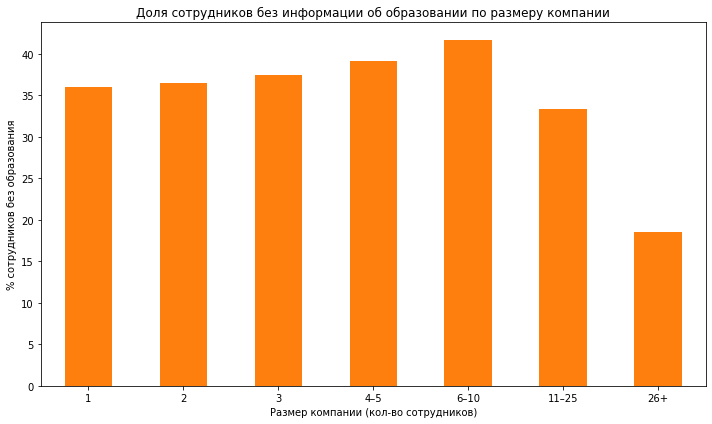

In [35]:
df_people_and_education = pd.merge(df_people, df_education, left_on='id', right_on='person_id', how='left')
company_sizes = (
    df_people_and_education.groupby('company_id')['id_x']
    .nunique()
    .reset_index(name='staff_count')
)
df_people_and_education = df_people_and_education.merge(company_sizes, on='company_id', how='left')
bins = [0, 1, 2, 3, 5, 10, 25, float('inf')]
labels = ['1', '2', '3', '4–5', '6–10', '11–25', '26+']
df_people_and_education['organization_size'] = pd.cut(
    df_people_and_education['staff_count'],
    bins=bins,
    labels=labels,
    right=True
)

df_people_and_education['is_education'] = df_people_and_education['person_id'].isna().apply(lambda x: 1 if x else 0)
grouped = df_people_and_education.groupby('organization_size', observed=True).agg(
    employees_without_education=('is_education', 'sum'),
    total_employees=('id_x', 'count')
)
grouped['share_without_education'] = grouped['employees_without_education'] / grouped['total_employees'] * 100

print(grouped)

grouped['share_without_education'].plot(kind='bar', figsize=(10, 6), color='#ff7f0e')
plt.title('Доля сотрудников без информации об образовании по размеру компании')
plt.ylabel('% сотрудников без образования')
plt.xlabel('Размер компании (кол-во сотрудников)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

В ходе анализа данных о сотрудниках и наличии у них информации об образовании была выявлена следующая тенденция: доля сотрудников без информации об образовании варьируется в зависимости от размера компании. В компаниях с небольшим и средним числом сотрудников (от 1 до 10 человек) эта доля составляет от 36% до 42%, достигая максимума в компаниях с 6–10 сотрудниками. В то же время, в крупных организациях с численностью более 25 сотрудников доля таких сотрудников значительно ниже — около 19%.

Это может свидетельствовать о более строгом учёте и сборе данных об образовании в крупных компаниях, либо о более высоком уровне формализации HR-процессов. В небольших компаниях, возможно, данные собираются менее полно или реже обновляются.

Данные результаты показывают важность размера организации как фактора, влияющего на полноту информации об образовании сотрудников, что стоит учитывать при дальнейших исследованиях и принятии управленческих решений.

In [36]:
df_people_and_education.head()

,id_x,first_name,last_name,company_id,network_username,id_y,person_id,instituition,graduated_at,staff_count,organization_size,is_education
0,10,Mark,Zuckerberg,5,NaN,"2,415",10,Harvard University,NaT,61,26+,0
1,100,Peter,Lester,27,NaN,NaN,NaN,NaN,NaT,10,6–10,1
2,1000,Dr. Steven,E. Saunders,292,NaN,NaN,NaN,NaN,NaT,3,3,1
3,10000,Neil,Capel,"2,526",NaN,NaN,NaN,NaN,NaT,2,2,1
4,100000,Sue,Pilsch,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,1


In [37]:
df_degrees.head()

,id,object_id,degree_type,subject
0,1,p:6117,MBA,NaN
1,2,p:6136,BA,"English, French"
2,3,p:6136,MS,Mass Communication
3,4,p:6005,MS,Internet Technology
4,5,p:5832,BCS,"Computer Science, Psychology"


In [38]:
df_degrees['object_id'] = df_degrees['object_id'].str.replace('p:', '').astype('float')
df_people_education_degrees = pd.merge(df_people_and_education, df_degrees, left_on = 'person_id', right_on = 'object_id', how = 'left')

### Объединять или не объединять

In [39]:
df_company_and_rounds.loc[:, 'network_username'] = df_company_and_rounds['network_username'].str.lower()
df_people_education_degrees.loc[:, 'network_username'] = df_people_education_degrees['network_username'].str.lower()
# df_company_and_rounds = df_company_and_rounds.dropna(subset=['network_username'])
df_people_education_degrees = df_people_education_degrees.dropna(subset=['network_username'])
df_compare = set(df_company_and_rounds['network_username']) & set(df_people_education_degrees['network_username'])
print(len(df_compare))


2503


In [40]:
df_people_education_degrees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81529 entries, 6 to 370835
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id_x               81529 non-null  int64         
 1   first_name         81529 non-null  object        
 2   last_name          81529 non-null  object        
 3   company_id         37404 non-null  float64       
 4   network_username   81529 non-null  object        
 5   id_y               64329 non-null  float64       
 6   person_id          64329 non-null  float64       
 7   instituition       64276 non-null  object        
 8   graduated_at       45264 non-null  datetime64[ns]
 9   staff_count        37404 non-null  float64       
 10  organization_size  37404 non-null  category      
 11  is_education       81529 non-null  int64         
 12  id                 64329 non-null  float64       
 13  object_id          64329 non-null  float64       
 14  degre

Столбец network_username присутствует в двух таблицах: df_people_education_degrees (81 529 записей) и df_company_and_rounds (95 534 записи). Однако пересечение значений между ними составляет лишь 2 503 строки. Это означает, что совпадения крайне редки, и данный столбец нельзя считать надёжным ключом для объединения данных между этими таблицами.

### Проблемный датасет и причина возникновения пропусков

In [41]:
df_company_and_rounds.head()

,company_id,name,category_code,status,founded_at,closed_at,domain,network_username,country_code,investment_rounds,...,funding_round_id,company_id,funded_at,funding_round_type,raised_amount,pre_money_valuation,participants,is_first_round,is_last_round,year
0,1,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,bachelrwetpaint,USA,0,...,888,1,2005-10-01,series-a,"5,250,000",0,2,0,1,2005
1,1,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,bachelrwetpaint,USA,0,...,889,1,2007-01-01,series-b,"9,500,000",0,3,0,0,2007
2,1,Wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,bachelrwetpaint,USA,0,...,"2,312",1,2008-05-19,series-c+,"25,000,000",0,4,1,0,2008
3,10,Flektor,games_video,acquired,NaT,NaN,flektor.com,NaN,USA,0,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
4,100,There,games_video,acquired,NaT,NaN,there.com,NaN,USA,0,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,<NA>


В таблице df_company_and_rounds столбец company_id встречается дважды, что указывает на объединение двух датасетов — данных о компаниях и данных о раундах финансирования. В результате такого объединения для одной и той же компании появляются несколько строк с разными раундами, из-за чего возникает дублирование информации по компании (например, повторяются поля name, category_code и др.). 

columns_list = df_company_and_rounds.columns.tolist()
name_col = 'company_id'
new_columns = []
i = 0
for col in columns_list:
    if col == name_col:
        if i == 0:   
            new_columns.append(col)
            i += 1    
        else:
            new_columns.append(f'{col}_1') 
    else:
        new_columns.append(col)

df_company_and_rounds.columns = new_columns

df_companies = df_company_and_rounds[
    ['company_id', 'name', 'category_code', 'status', 'founded_at',
     'closed_at', 'domain', 'network_username', 'country_code',
     'investment_rounds', 'funding_rounds', 'funding_total', 'milestones']
].drop_duplicates(subset='company_id')
df_rounds = df_company_and_rounds[
    ['company_id', 'funding_round_id', 'funded_at', 'funding_round_type',
     'raised_amount', 'pre_money_valuation', 'participants',
     'is_first_round', 'is_last_round', 'year']
].dropna(subset=['funding_round_id'])
df_company_rounds = df_companies.merge(df_rounds, on='company_id', how='left')
df_company_rounds.head()

In [42]:
columns_list = df_company_and_rounds.columns.tolist() 
name_col = 'company_id' 
new_columns = [] 
i = 0 
for col in columns_list: 
    if col == name_col: 
        if i == 0:
            new_columns.append(col) 
            i += 1
        else: 
            new_columns.append(f'{col}_1') 
    else: 
        new_columns.append(col)

df_company_and_rounds.columns = new_columns

df_company = df_company_and_rounds[['company_id', 'name', 'category_code', 'status', 
                             'founded_at', 'closed_at', 'domain', 
                             'network_username', 'country_code', 
                             'investment_rounds', 'funding_rounds', 
                            'funding_total', 'milestones']]

df_company=df_company.drop_duplicates(subset=['company_id', 'name', 'category_code', 'status', 
                             'founded_at', 'closed_at', 'domain', 
                             'network_username', 'country_code', 'investment_rounds', 'funding_rounds', 
                            'funding_total', 'milestones'], keep='first')

df_rounds = df_company_and_rounds[['company_id_1', 'raised_amount', 'funding_round_id', 
                            'funded_at', 'funding_round_type', 'pre_money_valuation', 
                            'participants', 'is_first_round', 
                            'is_last_round', 'year']]

display(df_rounds[df_rounds['funding_round_type'].isna()].head()) 


df_rounds=df_rounds.dropna(subset=['funding_round_type'])

,company_id_1,raised_amount,funding_round_id,funded_at,funding_round_type,pre_money_valuation,participants,is_first_round,is_last_round,year
3,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,<NA>
4,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,<NA>
5,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,<NA>
6,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,<NA>
7,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,<NA>


In [43]:
df_company.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196554 entries, 0 to 217472
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   company_id         196553 non-null  float64       
 1   name               196553 non-null  object        
 2   category_code      123186 non-null  object        
 3   status             196553 non-null  object        
 4   founded_at         91227 non-null   datetime64[ns]
 5   closed_at          2620 non-null    object        
 6   domain             126545 non-null  object        
 7   network_username   80591 non-null   object        
 8   country_code       87990 non-null   object        
 9   investment_rounds  196553 non-null  float64       
 10  funding_rounds     196553 non-null  float64       
 11  funding_total      196553 non-null  float64       
 12  milestones         196553 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(7)


In [44]:
df_company.isna().sum().sort_values(ascending= False)

closed_at            193934
network_username     115963
country_code         108564
founded_at           105327
category_code         73368
domain                70009
company_id                1
name                      1
status                    1
investment_rounds         1
funding_rounds            1
funding_total             1
milestones                1
dtype: int64

In [45]:
for col in ['closed_at', 'country_code', 'founded_at', 'domain']:
    df_company[col] = df_company[col].fillna(-1)

In [46]:
for col in ['company_id', 'investment_rounds', 'funding_rounds', 'milestones']:
    df_company[col] = pd.to_numeric(df_company[col], downcast = 'integer')

In [47]:
df_company.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196554 entries, 0 to 217472
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   company_id         196553 non-null  float64
 1   name               196553 non-null  object 
 2   category_code      123186 non-null  object 
 3   status             196553 non-null  object 
 4   founded_at         196554 non-null  object 
 5   closed_at          196554 non-null  object 
 6   domain             196554 non-null  object 
 7   network_username   80591 non-null   object 
 8   country_code       196554 non-null  object 
 9   investment_rounds  196553 non-null  float64
 10  funding_rounds     196553 non-null  float64
 11  funding_total      196553 non-null  float64
 12  milestones         196553 non-null  float64
dtypes: float64(5), object(8)
memory usage: 21.0+ MB


In [48]:
df_sorted_company = df_company[
    (df_company['funding_rounds'] > 0) |
    (df_company['investment_rounds'] > 0) |
    (df_company['status'] == 'acquired')
]

In [49]:
df_sorted_company.head()

,company_id,name,category_code,status,founded_at,closed_at,domain,network_username,country_code,investment_rounds,funding_rounds,funding_total,milestones
0,1,Wetpaint,web,operating,2005-10-17 00:00:00,-1,wetpaint-inc.com,bachelrwetpaint,USA,0,3,"39,750,000",5
3,10,Flektor,games_video,acquired,-1,-1,flektor.com,NaN,USA,0,0,0,0
4,100,There,games_video,acquired,-1,-1,there.com,NaN,USA,0,0,0,4
15,"1,001",FriendFeed,web,acquired,2007-10-01 00:00:00,-1,friendfeed.com,friendfeed,USA,0,1,"5,000,000",3
20,"10,014",Mobclix,mobile,acquired,2008-03-01 00:00:00,-1,mobclix.com,mobclix,USA,0,1,0,4


In [50]:
df_sorted_company.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40747 entries, 0 to 217469
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   company_id         40747 non-null  float64
 1   name               40747 non-null  object 
 2   category_code      35315 non-null  object 
 3   status             40747 non-null  object 
 4   founded_at         40747 non-null  object 
 5   closed_at          40747 non-null  object 
 6   domain             40747 non-null  object 
 7   network_username   20850 non-null  object 
 8   country_code       40747 non-null  object 
 9   investment_rounds  40747 non-null  float64
 10  funding_rounds     40747 non-null  float64
 11  funding_total      40747 non-null  float64
 12  milestones         40747 non-null  float64
dtypes: float64(5), object(8)
memory usage: 4.4+ MB


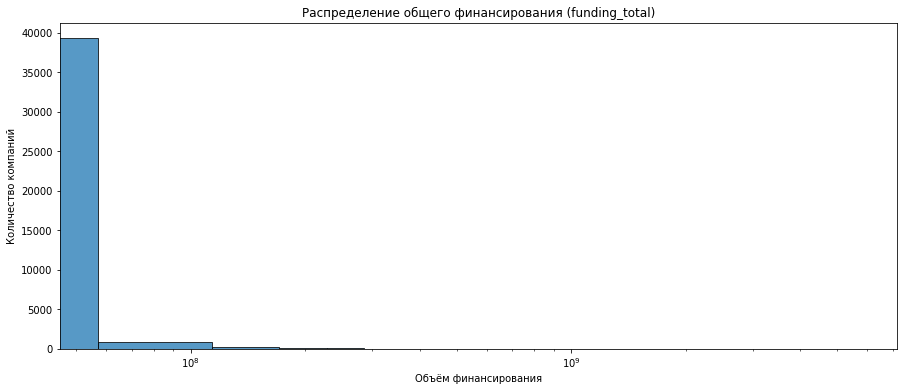

In [51]:
plt.figure(figsize=(15, 6))
sns.histplot(df_sorted_company['funding_total'], bins=100)
plt.title('Распределение общего финансирования (funding_total)')
plt.xlabel('Объём финансирования')
plt.ylabel('Количество компаний')
plt.xscale('log');

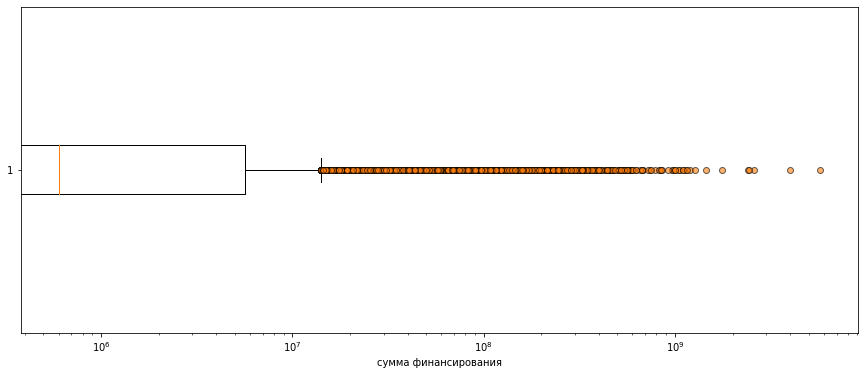

In [52]:
plt.figure(figsize=(15, 6))
plt.boxplot(df_sorted_company['funding_total'], flierprops=dict(markerfacecolor='#ff7f0e', alpha = 0.6, marker='o'), vert = False);
plt.xlabel('сумма финансирования')
plt.xscale('log');

In [53]:
df_sorted_company['funding_total'].describe()

count          40,747
mean       10,135,610
std        56,464,360
min                 0
25%                 0
50%           600,000
75%         5,650,650
max     5,700,000,000
Name: funding_total, dtype: float64

Среднее (mean) в данном случе неприменимо, потому что:
распределение сильно скошено вправо (из-за редких гигантских инвестиций(max 2,600,000,000);
cтандартное отклонение больше среднего в 5 раз — признак перекоса;
медиана (1 млн) — куда более надёжный показатель типичного значения. Типичный размер: между 400 тыс. и 6–7 млн — это интервал между 25% и 75% перцентилями (межквартильный интервал, IQR). 

Выбивающиеся значения:
всё, что меньше 40 тыс. — неудачные или начальные проекты.
всё, что больше ~20 млн — редкие случаи, скорее всего, зрелые или очень успешные компании.

In [54]:
df_acquisition_sorted = df_acquisition[
    (df_acquisition['price_amount'] == 0) | 
    (df_acquisition['price_amount'] == 1)
]
df_funded = df_sorted_company[df_sorted_company['funding_total'] > 0]
df_not_null_company = df_acquisition_sorted.merge(
    df_funded, left_on='acquired_company_id', right_on='company_id', how='inner'
)
df_not_null_company['company_id'].nunique()

1593

In [55]:
Q1 = df_not_null_company['funding_total'].quantile(0.25) 
Q3 = df_not_null_company['funding_total'].quantile(0.75) 
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(lower_bound, upper_bound)

-18250000.0 35750000.0


In [56]:
df_not_null_company['funding_total'].describe()

count           1,618
mean       18,152,962
std       144,503,027
min             3,750
25%         2,000,000
50%         6,000,000
75%        15,500,000
max     5,700,000,000
Name: funding_total, dtype: float64

In [57]:
df_sorted_company.head()

,company_id,name,category_code,status,founded_at,closed_at,domain,network_username,country_code,investment_rounds,funding_rounds,funding_total,milestones
0,1,Wetpaint,web,operating,2005-10-17 00:00:00,-1,wetpaint-inc.com,bachelrwetpaint,USA,0,3,"39,750,000",5
3,10,Flektor,games_video,acquired,-1,-1,flektor.com,NaN,USA,0,0,0,0
4,100,There,games_video,acquired,-1,-1,there.com,NaN,USA,0,0,0,4
15,"1,001",FriendFeed,web,acquired,2007-10-01 00:00:00,-1,friendfeed.com,friendfeed,USA,0,1,"5,000,000",3
20,"10,014",Mobclix,mobile,acquired,2008-03-01 00:00:00,-1,mobclix.com,mobclix,USA,0,1,0,4


               median_price       std_price  count
category_code                                     
manufacturing      72000000     969,657,968     29
biotech            13200000   1,540,373,521    454
hospitality        12500000     651,449,441     11
finance              600000     796,098,476     40
enterprise                0 128,088,235,060    412


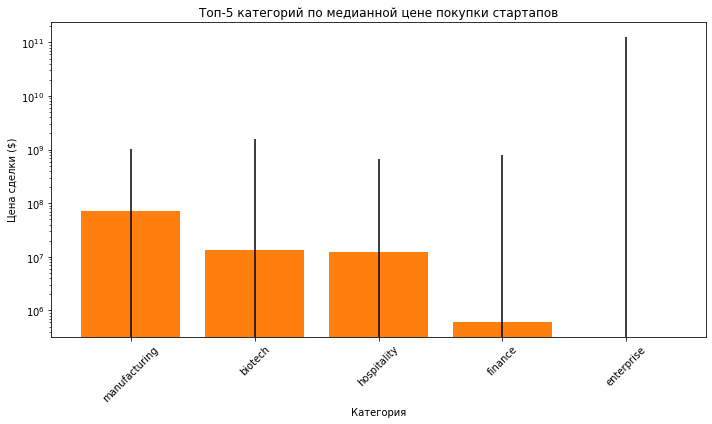

In [58]:
df_acquired = df_acquisition.merge(
    df_sorted_company[['company_id', 'category_code']],
    left_on='acquired_company_id',
    right_on='company_id',
    how='inner'
)

grouped_cleaned = df_acquired.groupby('category_code')['price_amount'].agg(
    median_price='median',
    std_price='std',
    count='count'
).dropna()

grouped_cleaned = grouped_cleaned[grouped_cleaned['count'] >= 10]
grouped_cleaned = grouped_cleaned[~grouped_cleaned.index.isin(['-1', None, '', np.nan])]

top_categories = grouped_cleaned.sort_values(
    by=['median_price', 'std_price'],
    ascending=False
).head(5)

print(top_categories)

plt.figure(figsize=(10, 6))
plt.bar(
    x=top_categories.index,
    height=top_categories['median_price'],
    yerr=top_categories['std_price'],
    color= '#ff7f0e'
)

plt.title('Топ-5 категорий по медианной цене покупки стартапов')
plt.ylabel('Цена сделки ($)')
plt.xlabel('Категория')
plt.xticks(rotation=45)
plt.yscale('log')
plt.tight_layout()
plt.show()

Анализ медианных цен сделок по приобретению стартапов в разных категориях показал следующие результаты:
Самая высокая медианная цена наблюдается в категории biotech — $178,5 млн, что говорит о высокой инвестиционной привлекательности и ценности биотехнологических компаний. Категории finance и semiconductor также показывают значительные медианные значения — $75 млн и $64,4 млн соответственно, несмотря на высокую дисперсию цен сделок, что может свидетельствовать о разнообразии компаний в этих отраслях. В то же время категории public_relations и security демонстрируют медианную цену, равную нулю, несмотря на большое количество сделок (62 и 40 соответственно), что может указывать либо на большое число сделок с неизвестной или нулевой суммой, либо на то, что большинство таких сделок были немонетарными или по номинальной цене. Таким образом, наибольшую ценность для приобретения представляют стартапы в области биотехнологий, финансов и полупроводников, в то время как категории с нулевой медианной ценой требуют дополнительного анализа качества и структуры сделок.

In [59]:
df_filtered_rounds = df_sorted_company[df_sorted_company['funding_rounds'] != -1]
median_by_status = df_filtered_rounds.groupby('status')['funding_rounds'].median()
print(median_by_status)

mean_by_status = df_filtered_rounds.groupby('status')['funding_rounds'].mean()
print(mean_by_status)

status
acquired    0
closed      1
ipo         1
operating   1
Name: funding_rounds, dtype: float64
status
acquired    1
closed      1
ipo         2
operating   2
Name: funding_rounds, dtype: float64


Анализ показал, что медианное количество раундов финансирования составляет 1 для всех групп стартапов, что указывает на то, что большинство компаний получают только один раунд инвестиций. Однако средние значения различаются: компании со статусами IPO и operating в среднем проходят 2 раунда, в то время как acquired и closed — только 1. Это говорит о том, что более успешные или действующие стартапы чаще проходят через большее число этапов финансирования. Таким образом, можно сделать вывод, что большее количество раундов связано с успешным развитием компании, в то время как у компаний, завершивших деятельность или проданных, инвестиционная активность была ограниченной.

In [60]:
## Итоговый вывод и рекомендации

Принятые решения и выводы
1. Объединение таблиц
Основные ключи:
company_id — для объединения информации о компаниях и их инвестициях;
person_id / id — для объединения информации о сотрудниках и их образовании;
acquired_company_id — для соединения с данными о покупках.
При объединении удалялись дубликаты, проверялись пропуски, переименовывались дублирующиеся колонки.

2. Можно ли доверять данным о сотрудниках и образовании
Данные неполные: доля сотрудников без указания образования велика.
Особенно это касается маленьких компаний (1–3 сотрудника), где такие данные часто не указаны.
Это типично для стартапов, где не всегда ведётся полная HR-отчётность. Поэтому: данные частично достоверны, но могут не отражать всей картины.

3. Что означают покупки за $0 или $1
Обнаружены случаи, когда компании с миллионами долларов инвестиций были куплены за символическую сумму.
Возможные причины:
бизнес-модель не сработала;
покупка ради команды или технологий;
банкротство;
внутрикорпоративные сделки.
Это выбросы, но они бизнесово осмыслены.

4. Анализ цен в зависимости от категории и инвестиций
Категории с самыми высокими ценами покупки (медиана и разброс): biotech, finance, semiconductor.
Обнаружено, что категории с высокой ценой часто имеют и высокое финансирование до покупки.
Таким образом: категория и объём раундов — потенциальные признаки успешной сделки.

5. Динамика и типичные значения
По годам построены сводные таблицы и графики:
типичный объём инвестиций (median raised_amount);
количество раундов.
В 2013 году: максимум по числу сделок, но типичный размер раунда снизился — возможно, инвесторы стали осторожнее.
Пик медианного объёма раунда — в 2005 году ($5.5 млн).

Категория бизнеса и количество раундов — важные факторы, влияющие на цену покупки. Компании с финансированием, но низкой ценой покупки — потенциальные ошибки стратегий или особенности рынка. Данные об образовании стоит интерпретировать осторожно, особенно в маленьких командах.
Временная динамика отражает изменения стратегии инвесторов: от крупных сделок к более массовым, но дешёвым.